In [1]:
# 📦 Step 1: Install dependencies
!pip install mediapipe opencv-python ffmpeg-python matplotlib


In [2]:
# 📁 Step 2: Upload your .webm file
from google.colab import files

uploaded = files.upload()  # Upload your .webm file
video_path = list(uploaded.keys())[0]
print(f"🎥 Uploaded file: {video_path}")


Saving Test Video More Eye Contact.webm to Test Video More Eye Contact (1).webm
🎥 Uploaded file: Test Video More Eye Contact (1).webm


In [3]:
# 🎞️ Step 3: Extract frames using ffmpeg (1 frame per second)
import ffmpeg
import os

frame_folder = "frames_ffmpeg"
os.makedirs(frame_folder, exist_ok=True)

(
    ffmpeg
    .input(video_path)
    .output(f'{frame_folder}/frame_%04d.jpg', r=1)  # r = 1 frame per second
    .run()
)

# Count how many frames were extracted
extracted_frames = len([f for f in os.listdir(frame_folder) if f.endswith('.jpg')])
print(f"✅ Extracted {extracted_frames} frame(s) into `{frame_folder}/`")


✅ Extracted 202 frame(s) into `frames_ffmpeg/`


In [4]:
# 👁️ Step 4: Run MediaPipe Face Mesh and save previews
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

preview_folder = "landmark_previews"
os.makedirs(preview_folder, exist_ok=True)

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=(0, 255, 0))

for filename in sorted(os.listdir(frame_folder))[:10]:  # first 10 frames for preview
    if not filename.endswith(".jpg"):
        continue

    image_path = os.path.join(frame_folder, filename)
    image = cv2.imread(image_path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec
            )

    out_path = os.path.join(preview_folder, f"preview_{filename}")
    cv2.imwrite(out_path, image)

print("✅ Saved face mesh previews to `landmark_previews/`")


✅ Saved face mesh previews to `landmark_previews/`


In [5]:
import cv2
import mediapipe as mp
import os
from matplotlib import pyplot as plt

# Initialize MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

input_folder = "frames_ffmpeg"  # where your full frames are
output_folder = "itracker_inputs"
os.makedirs(output_folder, exist_ok=True)

# Define landmark indices for eyes and general face box
LEFT_EYE = [33, 133]      # outer eye corners (left eye)
RIGHT_EYE = [362, 263]    # outer eye corners (right eye)
FACE_BOX = [10, 152, 234, 454]  # forehead, chin, left cheek, right cheek

def get_bbox(landmarks, indices, width, height, padding=10):
    x_coords = [landmarks[i].x * width for i in indices]
    y_coords = [landmarks[i].y * height for i in indices]
    x_min = max(int(min(x_coords)) - padding, 0)
    x_max = min(int(max(x_coords)) + padding, width)
    y_min = max(int(min(y_coords)) - padding, 0)
    y_max = min(int(max(y_coords)) + padding, height)
    return x_min, y_min, x_max, y_max

# Process each frame
for filename in sorted(os.listdir(input_folder)):
    if not filename.endswith(".jpg"):
        continue

    path = os.path.join(input_folder, filename)
    image = cv2.imread(path)
    h, w, _ = image.shape
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        face = results.multi_face_landmarks[0]
        landmarks = face.landmark

        lx1, ly1, lx2, ly2 = get_bbox(landmarks, LEFT_EYE, w, h)
        rx1, ry1, rx2, ry2 = get_bbox(landmarks, RIGHT_EYE, w, h)
        fx1, fy1, fx2, fy2 = get_bbox(landmarks, FACE_BOX, w, h)

        left_eye_crop = image[ly1:ly2, lx1:lx2]
        right_eye_crop = image[ry1:ry2, rx1:rx2]
        face_crop = image[fy1:fy2, fx1:fx2]

        base = filename.replace(".jpg", "")
        cv2.imwrite(f"{output_folder}/{base}_left_eye.jpg", left_eye_crop)
        cv2.imwrite(f"{output_folder}/{base}_right_eye.jpg", right_eye_crop)
        cv2.imwrite(f"{output_folder}/{base}_face.jpg", face_crop)

print("✅ Done cropping all eyes and faces.")


✅ Done cropping all eyes and faces.


PREVIEW DATA

✅ Previewing: frame_0001


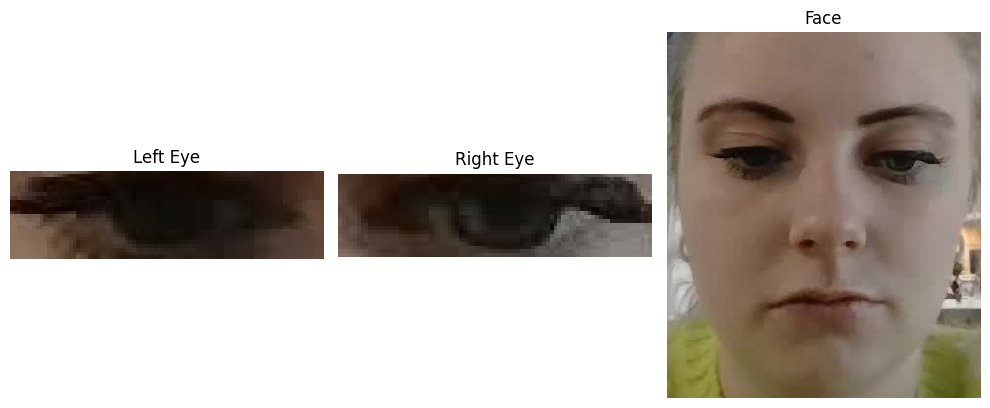

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

output_folder = "itracker_inputs"

# Get a list of all cropped files
cropped_files = sorted(os.listdir(output_folder))

# Automatically find a frame that has all three images
samples = sorted(set(f.split("_")[0] + "_" + f.split("_")[1] for f in cropped_files if "left_eye" in f))
sample = samples[0]  # pick the first one
print(f"✅ Previewing: {sample}")

# Load images
left = Image.open(f"{output_folder}/{sample}_left_eye.jpg")
right = Image.open(f"{output_folder}/{sample}_right_eye.jpg")
face = Image.open(f"{output_folder}/{sample}_face.jpg")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(left)
axs[0].set_title("Left Eye")
axs[1].imshow(right)
axs[1].set_title("Right Eye")
axs[2].imshow(face)
axs[2].set_title("Face")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [12]:
import os
import cv2
import numpy as np

input_folder = "/content/itracker_inputs"
grid_size = 25

# Function to calculate face grid
def create_face_grid(img_width, img_height, bbox, grid_size=25):
    x1, y1, x2, y2 = bbox
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    norm_x = center_x / img_width
    norm_y = center_y / img_height

    grid_x = min(int(norm_x * grid_size), grid_size - 1)
    grid_y = min(int(norm_y * grid_size), grid_size - 1)

    grid = np.zeros((grid_size, grid_size), dtype=np.uint8)
    grid[grid_y, grid_x] = 1
    return grid

# Loop through all face crops and create face grids
face_files = sorted([f for f in os.listdir(input_folder) if f.endswith("_face.jpg")])
print(f"🔁 Creating face grids for {len(face_files)} frames...")

for face_file in face_files:
    frame_id = face_file.replace("_face.jpg", "")
    face_path = os.path.join(input_folder, face_file)

    image = cv2.imread(face_path)
    h, w, _ = image.shape

    # Use entire face image as bbox (simplified assumption)
    grid = create_face_grid(w, h, (0, 0, w, h))  # assumes face takes full crop

    # Save grid
    grid_path = os.path.join(input_folder, f"{frame_id}_face_grid.npy")
    np.save(grid_path, grid)

print("✅ Done! Face grids saved as .npy files.")


🔁 Creating face grids for 202 frames...
✅ Done! Face grids saved as .npy files.


Preview. face grids

In [13]:
grid_files = [f for f in os.listdir(input_folder) if f.endswith("_face_grid.npy")]
print(f"✅ Found {len(grid_files)} face grid files:")
print(grid_files[:5])


✅ Found 202 face grid files:
['frame_0194_face_grid.npy', 'frame_0136_face_grid.npy', 'frame_0195_face_grid.npy', 'frame_0182_face_grid.npy', 'frame_0198_face_grid.npy']


In [20]:
model_path = "checkpoint (1).pth"  # or update with the correct filename


In [17]:
import argparse
import os
import shutil
import time, math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import torch.utils.model_zoo as model_zoo
from torch.autograd.variable import Variable

'''
Pytorch model for the iTracker.

Author: Petr Kellnhofer ( pkel_lnho (at) gmai_l.com // remove underscores and spaces), 2018.

Website: http://gazecapture.csail.mit.edu/

Cite:

Eye Tracking for Everyone
K.Krafka*, A. Khosla*, P. Kellnhofer, H. Kannan, S. Bhandarkar, W. Matusik and A. Torralba
IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016

@inproceedings{cvpr2016_gazecapture,
Author = {Kyle Krafka and Aditya Khosla and Petr Kellnhofer and Harini Kannan and Suchendra Bhandarkar and Wojciech Matusik and Antonio Torralba},
Title = {Eye Tracking for Everyone},
Year = {2016},
Booktitle = {IEEE Conference on Computer Vision and Pattern Recognition (CVPR)}
}

'''


class ItrackerImageModel(nn.Module):
    # Used for both eyes (with shared weights) and the face (with unqiue weights)
    def __init__(self):
        super(ItrackerImageModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.CrossMapLRN2d(size=5, alpha=0.0001, beta=0.75, k=1.0),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.CrossMapLRN2d(size=5, alpha=0.0001, beta=0.75, k=1.0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class FaceImageModel(nn.Module):

    def __init__(self):
        super(FaceImageModel, self).__init__()
        self.conv = ItrackerImageModel()
        self.fc = nn.Sequential(
            nn.Linear(12*12*64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

class FaceGridModel(nn.Module):
    # Model for the face grid pathway
    def __init__(self, gridSize = 25):
        super(FaceGridModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(gridSize * gridSize, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



class ITrackerModel(nn.Module):


    def __init__(self):
        super(ITrackerModel, self).__init__()
        self.eyeModel = ItrackerImageModel()
        self.faceModel = FaceImageModel()
        self.gridModel = FaceGridModel()
        # Joining both eyes
        self.eyesFC = nn.Sequential(
            nn.Linear(2*12*12*64, 128),
            nn.ReLU(inplace=True),
            )
        # Joining everything
        self.fc = nn.Sequential(
            nn.Linear(128+64+128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
            )

    def forward(self, faces, eyesLeft, eyesRight, faceGrids):
        # Eye nets
        xEyeL = self.eyeModel(eyesLeft)
        xEyeR = self.eyeModel(eyesRight)
        # Cat and FC
        xEyes = torch.cat((xEyeL, xEyeR), 1)
        xEyes = self.eyesFC(xEyes)

        # Face net
        xFace = self.faceModel(faces)
        xGrid = self.gridModel(faceGrids)

        # Cat all
        x = torch.cat((xEyes, xFace, xGrid), 1)
        x = self.fc(x)

        return x

In [23]:
checkpoint = torch.load("checkpoint (1).pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint["state_dict"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [25]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

input_folder = "/content/itracker_inputs"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_image_tensor(path):
    img = Image.open(path).convert("RGB")
    return image_transform(img).unsqueeze(0).to(device)

def load_face_grid(path):
    grid = np.load(path).flatten()
    return torch.tensor(grid, dtype=torch.float32).unsqueeze(0).to(device)

def load_inputs(frame_id):
    base = os.path.join(input_folder, frame_id)
    left_eye = load_image_tensor(f"{base}_left_eye.jpg")
    right_eye = load_image_tensor(f"{base}_right_eye.jpg")
    face = load_image_tensor(f"{base}_face.jpg")
    grid = load_face_grid(f"{base}_face_grid.npy")
    return face, left_eye, right_eye, grid

# Find all frames
frame_ids = sorted(set(f.replace("_left_eye.jpg", "") for f in os.listdir(input_folder) if f.endswith("_left_eye.jpg")))
print(f"🔎 Found {len(frame_ids)} frames to predict.")

# Predict
results = []

model.eval()
with torch.no_grad():
    for frame_id in frame_ids:
        try:
            face, left, right, grid = load_inputs(frame_id)
            output = model(face, left, right, grid)
            x, y = output[0].tolist()
            results.append({"frame_id": frame_id, "gaze_x": x, "gaze_y": y})
        except Exception as e:
            print(f"❌ Failed on {frame_id}: {e}")

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("gaze_predictions.csv", index=False)
print("✅ Gaze predictions saved to 'gaze_predictions.csv'")


🔎 Found 202 frames to predict.
✅ Gaze predictions saved to 'gaze_predictions.csv'


In [26]:
import pandas as pd

# Load predictions
df = pd.read_csv("gaze_predictions.csv")

print(f"✅ Loaded {len(df)} gaze predictions.")
df.head()


✅ Loaded 202 gaze predictions.


,frame_id,gaze_x,gaze_y
0,frame_0001,2.529752,-1.141002
1,frame_0002,2.826777,0.780178
2,frame_0003,0.632272,1.927537
3,frame_0004,3.252670,-1.841706
4,frame_0005,3.428404,-1.827353


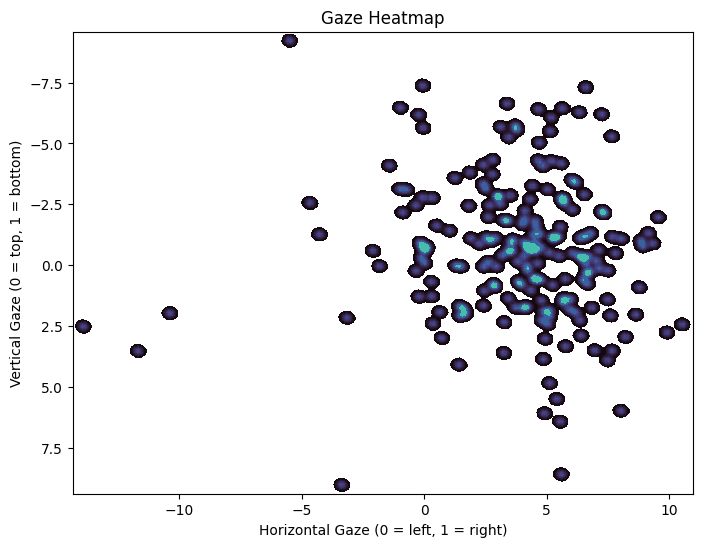

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract gaze coordinates
x = df["gaze_x"]
y = df["gaze_y"]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=x,
    y=y,
    fill=True,
    cmap="mako",
    bw_adjust=0.1,
    thresh=0.05
)
plt.title("Gaze Heatmap")
plt.xlabel("Horizontal Gaze (0 = left, 1 = right)")
plt.ylabel("Vertical Gaze (0 = top, 1 = bottom)")
plt.gca().invert_yaxis()  # (0,0) is top-left, like screen coordinates
plt.show()


🧠 Interpretation
🔥 Brighter areas = where the person looked most often

Top-left = (0, 0) = usually aligned with camera

If the bright area is near the center → good eye contact!



In [30]:
def is_eye_contact(x, y, center=0.5, threshold=0.2):
    return abs(x - center) < threshold and abs(y - center) < threshold

# Add a new column to the DataFrame
df["eye_contact"] = df.apply(lambda row: is_eye_contact(row["gaze_x"], row["gaze_y"]), axis=1)

# Compute % of frames with eye contact
eye_contact_percent = df["eye_contact"].mean() * 100
print(f"✅ Eye contact maintained for {eye_contact_percent:.1f}% of the interview.")


✅ Eye contact maintained for 0.0% of the interview.


In [31]:
if eye_contact_percent > 80:
    feedback = f"✅ Excellent! You maintained strong eye contact for {eye_contact_percent:.1f}% of your interview."
elif eye_contact_percent > 60:
    feedback = f"🙂 Great effort! You maintained eye contact for {eye_contact_percent:.1f}%, which is good — but there's still room to improve."
elif eye_contact_percent > 40:
    feedback = f"⚠️ You made eye contact for {eye_contact_percent:.1f}% of the time. Try to stay focused on the camera more often."
else:
    feedback = f"👀 Eye contact was low ({eye_contact_percent:.1f}%). Practicing steady focus on the camera will help you connect better with your interviewer."

print(feedback)


👀 Eye contact was low (0.0%). Practicing steady focus on the camera will help you connect better with your interviewer.
